

# Imports



In [1]:
import pvlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, Baseline, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, RMSE, QuantileLoss


/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import torch
# Number of GPUs available
print("GPUs available:", torch.cuda.device_count())

GPUs available: 1


# PV Class and important functions

In [3]:
# Class
import pvlib

class PVPark:
    def __init__(self, name, latitude, longitude, altitude, tz, tilt, azimuth, nominal_capacity):
        self.location = pvlib.location.Location(latitude=latitude, longitude=longitude, altitude=altitude, tz=tz, name=name)
        self.tilt = tilt
        self.azimuth = azimuth
        self.nominal_capacity = nominal_capacity

    @classmethod
    def from_dataframe(cls, df, index=0):
        row = df.iloc[index]

        lat = row['latitude']
        azimuth = row['azimuth'] if pd.notnull(row['azimuth']) else 180.0
        tilt = row['tilt'] if pd.notnull(row['tilt']) else lat
        altitude = row['altitude'] if pd.notnull(row['altitude']) else None

        return cls(
            name=row['name'],
            latitude=lat,
            longitude=row['longitude'],
            altitude=altitude,
            tz=row['tz'],
            tilt=tilt,
            azimuth=azimuth,
            nominal_capacity=row['nominal_capacity']
        )

In [4]:
def get_solar_position(df, park):
    # Full time index in local time with timezone
    times = pd.to_datetime(df['collect_time']).dt.tz_localize(park.location.tz, ambiguous=False, nonexistent='NaT')
    
    # Get solar position
    solpos = park.location.get_solarposition(times)

    # Reset Index
    solpos['collect_time'] = solpos.index
    solpos = solpos.reset_index(drop=True)

    # Reset time to naive
    solpos['collect_time'] = solpos['collect_time'].dt.tz_localize(None)
    solpos = solpos.drop_duplicates(subset='collect_time')

    # Keep columns and calculate cos_zenith
    solpos = solpos[['collect_time', 'azimuth', 'zenith']]
    solpos = solpos.rename(columns={'azimuth': 'solar_azimuth', 'zenith': 'solar_zenith'})
    solpos['cos_zenith'] = np.clip(np.cos(np.radians(solpos['solar_zenith'])), 0, 1)

    # Merge the dataframes
    df['collect_time'] = pd.to_datetime(df['collect_time'])
    df = pd.merge(df, solpos, how='left', on='collect_time')
    df = df.interpolate(method='linear')
    
    return df

In [5]:
def estimate_dhi_dni(df, park):
    
    ghi = df['irradiance'].astype(np.float32).values
    ghi = pd.Series(ghi, index=df['collect_time'])

    zenith = df['solar_zenith'].astype(np.float32).values
    zenith = pd.Series(zenith, index=df['collect_time'])

    # Compute DHI and DNI using the Erbs model
    dhi_dni = pvlib.irradiance.erbs(ghi, zenith, ghi.index)[['dhi', 'dni']]
    
    # Reset index
    dhi_dni['collect_time']=dhi_dni.index
    dhi_dni = dhi_dni.reset_index(drop=True)

    # Merge the dataframes
    df = pd.merge(df, dhi_dni, how='left', on='collect_time')
    
    return df


In [6]:
def get_poa(df, park):
    # Full time index in global time
    new_df = df.set_index('collect_time')

    # Calculate POA for all time steps
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=park.tilt,
        surface_azimuth=park.azimuth,
        dni=new_df['dni'],
        ghi=new_df['irradiance'],
        dhi=new_df['dhi'],
        solar_zenith=new_df['solar_zenith'],
        solar_azimuth=new_df['solar_azimuth']
    )

    # Mask nighttime: set poa_global to 0 when sun is below horizon
    poa.loc[new_df['solar_zenith'] >= 90, ['poa_global', 'poa_direct', 'poa_diffuse']] = 0
    poa_global = poa[['poa_global']]
    
    # Reset Index
    poa_global['collect_time']=poa_global.index
    poa_global = poa_global.reset_index(drop=True)

    print(poa_global)

    # Merge the dataframes
    df = pd.merge(df, poa_global, how='left', on='collect_time')
    
    return df

In [7]:
def calc_aoi(df, park):
    df['aoi'] = pvlib.irradiance.aoi(
        surface_tilt=park.tilt,
        surface_azimuth=park.azimuth,
        solar_zenith=df['solar_zenith'],
        solar_azimuth=df['solar_azimuth']
    )
    df['cos_aoi'] = np.clip(np.cos(np.radians(df['aoi'])), 0, 1)

    return(df)

In [8]:
def scale_active_power(df, pv_park):
    # Scale and clip the target at 1.0
    df['active_power'] = (df['active_power'] / pv_park.nominal_capacity)
    df['active_power'] = df['active_power'].clip(upper=1.0)
    return df

In [9]:
def add_sin_cos_time(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Ensure datetime
    df["collect_time"] = pd.to_datetime(df["collect_time"])

    # Add minute of day
    df["minute_of_day"] = df["collect_time"].dt.hour * 60 + df["collect_time"].dt.minute

    # Cyclical encodings
    df["sin_time"] = np.sin(2 * np.pi * df["minute_of_day"] / 1440)
    df["cos_time"] = np.cos(2 * np.pi * df["minute_of_day"] / 1440)

    return df

In [10]:
def print_correlations(df):
    df_corr = df.corr()
    abs_corr = df_corr['active_power'].abs().sort_values(ascending=False)
    print(abs_corr)

In [11]:
def add_group_and_time_idx(df):
    # Ensure timestamp column is datetime
    df["collect_time"] = pd.to_datetime(df["collect_time"])

    # Extract day string for group_id
    df["group_id"] = df["collect_time"].dt.date.astype(str)

    # Sort just in case
    df = df.sort_values(by=["collect_time"])

    # Assign time_idx per group (e.g., 0 to 287)
    df["time_idx"] = df.groupby("group_id").cumcount()

    return df

In [12]:
def clean_and_reorder_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Columns to keep and reorder
    ordered_cols = [
        "group_id", "time_idx",
        "active_power", "irradiance", "poa_global",
        "cos_zenith", "cos_aoi", "dni", "dhi",
        "cos_time", "temperature", "wind_speed"
    ]

    # Only keep and reorder the relevant columns
    df = df[ordered_cols]

    return df

# Load  Training Data

## Load metadata and create park info

In [13]:
base_dir="/home/jovyan/work/pv-digital-twin"

In [14]:
df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/metadata.csv")
# Create PVPark instance from DataFrame
pv_park = PVPark.from_dataframe(df)
print(pv_park.location)
print(pv_park.tilt)
print(pv_park.azimuth)
print(pv_park.nominal_capacity)

Location: 
  name: Gasi-CN448
  latitude: 35.13
  longitude: 25.259
  altitude: 334.0
  tz: Europe/Athens
25.0
180.0
405.0


## Load unprocessed data

In [15]:
df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/data.csv")

meteo_df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/open-meteo-data.csv")

# df['irradiance'] = meteo_df['shortwave_radiation_instant']
# df['dhi'] = meteo_df['diffuse_radiation_instant']
# df['dni'] = meteo_df['direct_normal_irradiance_instant']
# df['temperature'] = meteo_df['temperature_2m']
# df['wind_speed'] = meteo_df['wind_speed_10m']

print(df.head())
print(len(df)/288)

          collect_time  temperature  irradiance  wind_speed  active_power
0  2023-08-12 00:00:00         20.6         0.0         8.5           0.0
1  2023-08-12 00:05:00         20.6         0.0         8.5           0.0
2  2023-08-12 00:10:00         20.6         0.0         8.5           0.0
3  2023-08-12 00:15:00         20.6         0.0         8.5           0.0
4  2023-08-12 00:20:00         20.6         0.0         8.5           0.0
539.0


## Feature Extraction

### Calculate solar posistion

In [16]:
df = get_solar_position(df, pv_park)

print(df.head())
print(len(df)/288)

         collect_time  temperature  irradiance  wind_speed  active_power  \
0 2023-08-12 00:00:00         20.6         0.0         8.5           0.0   
1 2023-08-12 00:05:00         20.6         0.0         8.5           0.0   
2 2023-08-12 00:10:00         20.6         0.0         8.5           0.0   
3 2023-08-12 00:15:00         20.6         0.0         8.5           0.0   
4 2023-08-12 00:20:00         20.6         0.0         8.5           0.0   

   solar_azimuth  solar_zenith  cos_zenith  
0     334.666746    125.907688         0.0  
1     336.063890    126.334839         0.0  
2     337.478988    126.739064         0.0  
3     338.911441    127.119826         0.0  
4     340.360572    127.476607         0.0  
539.0


### Estimate dhi & dni

In [17]:
df = estimate_dhi_dni(df, pv_park)

print(df.head())
print(len(df)/288)
print(df.isna().sum())

         collect_time  temperature  irradiance  wind_speed  active_power  \
0 2023-08-12 00:00:00         20.6         0.0         8.5           0.0   
1 2023-08-12 00:05:00         20.6         0.0         8.5           0.0   
2 2023-08-12 00:10:00         20.6         0.0         8.5           0.0   
3 2023-08-12 00:15:00         20.6         0.0         8.5           0.0   
4 2023-08-12 00:20:00         20.6         0.0         8.5           0.0   

   solar_azimuth  solar_zenith  cos_zenith  dhi  dni  
0     334.666746    125.907688         0.0  0.0  0.0  
1     336.063890    126.334839         0.0  0.0  0.0  
2     337.478988    126.739064         0.0  0.0  0.0  
3     338.911441    127.119826         0.0  0.0  0.0  
4     340.360572    127.476607         0.0  0.0  0.0  
539.0
collect_time     0
temperature      0
irradiance       0
wind_speed       0
active_power     0
solar_azimuth    0
solar_zenith     0
cos_zenith       0
dhi              0
dni              0
dtype: int64


### Calculate Poa Global

In [18]:
df = get_poa(df, pv_park)

print(df.head())
print(len(df)/288)

        poa_global        collect_time
0              0.0 2023-08-12 00:00:00
1              0.0 2023-08-12 00:05:00
2              0.0 2023-08-12 00:10:00
3              0.0 2023-08-12 00:15:00
4              0.0 2023-08-12 00:20:00
...            ...                 ...
155227         0.0 2025-01-31 23:35:00
155228         0.0 2025-01-31 23:40:00
155229         0.0 2025-01-31 23:45:00
155230         0.0 2025-01-31 23:50:00
155231         0.0 2025-01-31 23:55:00

[155232 rows x 2 columns]
         collect_time  temperature  irradiance  wind_speed  active_power  \
0 2023-08-12 00:00:00         20.6         0.0         8.5           0.0   
1 2023-08-12 00:05:00         20.6         0.0         8.5           0.0   
2 2023-08-12 00:10:00         20.6         0.0         8.5           0.0   
3 2023-08-12 00:15:00         20.6         0.0         8.5           0.0   
4 2023-08-12 00:20:00         20.6         0.0         8.5           0.0   

   solar_azimuth  solar_zenith  cos_zenith  dhi 

/tmp/ipykernel_4469/2499243660.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poa_global['collect_time']=poa_global.index


### Calculate Angle of Incidence

In [19]:
df = calc_aoi(df, pv_park)

print(df.head())
print(len(df)/288)

         collect_time  temperature  irradiance  wind_speed  active_power  \
0 2023-08-12 00:00:00         20.6         0.0         8.5           0.0   
1 2023-08-12 00:05:00         20.6         0.0         8.5           0.0   
2 2023-08-12 00:10:00         20.6         0.0         8.5           0.0   
3 2023-08-12 00:15:00         20.6         0.0         8.5           0.0   
4 2023-08-12 00:20:00         20.6         0.0         8.5           0.0   

   solar_azimuth  solar_zenith  cos_zenith  dhi  dni  poa_global         aoi  \
0     334.666746    125.907688         0.0  0.0  0.0         0.0  147.237342   
1     336.063890    126.334839         0.0  0.0  0.0         0.0  148.011989   
2     337.478988    126.739064         0.0  0.0  0.0         0.0  148.756741   
3     338.911441    127.119826         0.0  0.0  0.0         0.0  149.469407   
4     340.360572    127.476607         0.0  0.0  0.0         0.0  150.147688   

   cos_aoi  
0      0.0  
1      0.0  
2      0.0  
3      0.0

### Add sin and cos of time


In [20]:
df = add_sin_cos_time(df)

print(df.head())
print(len(df)/288)

         collect_time  temperature  irradiance  wind_speed  active_power  \
0 2023-08-12 00:00:00         20.6         0.0         8.5           0.0   
1 2023-08-12 00:05:00         20.6         0.0         8.5           0.0   
2 2023-08-12 00:10:00         20.6         0.0         8.5           0.0   
3 2023-08-12 00:15:00         20.6         0.0         8.5           0.0   
4 2023-08-12 00:20:00         20.6         0.0         8.5           0.0   

   solar_azimuth  solar_zenith  cos_zenith  dhi  dni  poa_global         aoi  \
0     334.666746    125.907688         0.0  0.0  0.0         0.0  147.237342   
1     336.063890    126.334839         0.0  0.0  0.0         0.0  148.011989   
2     337.478988    126.739064         0.0  0.0  0.0         0.0  148.756741   
3     338.911441    127.119826         0.0  0.0  0.0         0.0  149.469407   
4     340.360572    127.476607         0.0  0.0  0.0         0.0  150.147688   

   cos_aoi  minute_of_day  sin_time  cos_time  
0      0.0    

### Calculate Correlations

In [21]:
print_correlations(df)

active_power     1.000000
irradiance       0.992928
poa_global       0.972956
cos_zenith       0.893392
cos_aoi          0.888133
dni              0.865302
aoi              0.789415
solar_zenith     0.784313
dhi              0.757615
cos_time         0.751063
temperature      0.483604
wind_speed       0.293925
sin_time         0.165764
minute_of_day    0.086414
solar_azimuth    0.012350
collect_time     0.010018
Name: active_power, dtype: float64


## Data Cleaning and Preparing for TFT

### Autoscale active power

In [96]:
df = scale_active_power(df, pv_park)

print(df.head())
print(len(df)/288)

          collect_time  temperature  irradiance  wind_speed  active_power  \
0  2023-08-12 00:00:00    19.613000         0.0    3.001666           0.0   
1  2023-08-12 00:05:00    19.604667         0.0    3.034983           0.0   
2  2023-08-12 00:10:00    19.596333         0.0    3.068300           0.0   
3  2023-08-12 00:15:00    19.588000         0.0    3.101617           0.0   
4  2023-08-12 00:20:00    19.579667         0.0    3.134934           0.0   

   dhi  dni  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  
539.0


### Add group & time index

In [97]:
df = add_group_and_time_idx(df)

print(df.head())
print(len(df)/288)

         collect_time  temperature  irradiance  wind_speed  active_power  dhi  \
0 2023-08-12 00:00:00    19.613000         0.0    3.001666           0.0  0.0   
1 2023-08-12 00:05:00    19.604667         0.0    3.034983           0.0  0.0   
2 2023-08-12 00:10:00    19.596333         0.0    3.068300           0.0  0.0   
3 2023-08-12 00:15:00    19.588000         0.0    3.101617           0.0  0.0   
4 2023-08-12 00:20:00    19.579667         0.0    3.134934           0.0  0.0   

   dni    group_id  time_idx  
0  0.0  2023-08-12         0  
1  0.0  2023-08-12         1  
2  0.0  2023-08-12         2  
3  0.0  2023-08-12         3  
4  0.0  2023-08-12         4  
539.0


### Clean and Reorder Dataframe

In [27]:
df = clean_and_reorder_df(df)

print(df.head())
print(len(df)/288)

     group_id  time_idx  active_power  irradiance  poa_global  cos_zenith  \
0  2023-08-12         0           0.0         0.0         0.0         0.0   
1  2023-08-12         1           0.0         0.0         0.0         0.0   
2  2023-08-12         2           0.0         0.0         0.0         0.0   
3  2023-08-12         3           0.0         0.0         0.0         0.0   
4  2023-08-12         4           0.0         0.0         0.0         0.0   

   cos_aoi  dni  dhi  cos_time  temperature  wind_speed  
0      0.0  0.0  0.0  1.000000    19.613000    3.001666  
1      0.0  0.0  0.0  0.999762    19.604667    3.034983  
2      0.0  0.0  0.0  0.999048    19.596333    3.068300  
3      0.0  0.0  0.0  0.997859    19.588000    3.101617  
4      0.0  0.0  0.0  0.996195    19.579667    3.134934  
539.0


## Define Time Series Dataset for TFT

In [98]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder

tft_dataset = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="active_power",
    group_ids=["group_id"],

    max_encoder_length=1,
    min_encoder_length=1,
    max_prediction_length=287,
    min_prediction_length=287,
    # time_varying_known_reals=["irradiance", "poa_global", "cos_zenith", "cos_aoi", "dni", "dhi","cos_time", "temperature", "wind_speed"],
    time_varying_known_reals=["irradiance", "temperature", "wind_speed"],
    time_varying_unknown_reals=["active_power"],

    
    add_relative_time_idx=True,
    add_encoder_length=True,
    add_target_scales=False,  # ❗ disables auto-scaling of target
    allow_missing_timesteps=False, # optional

    categorical_encoders={'<entity-key>': NaNLabelEncoder(add_nan=True)},
)

In [99]:
print(tft_dataset)

TimeSeriesDataSet[length=539](
	time_idx='time_idx',
	target='active_power',
	group_ids=['group_id'],
	weight=None,
	max_encoder_length=1,
	min_encoder_length=1,
	min_prediction_idx=np.int64(0),
	min_prediction_length=287,
	max_prediction_length=287,
	static_categoricals=None,
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['irradiance', 'temperature', 'wind_speed'],
	time_varying_unknown_categoricals=None,
	time_varying_unknown_reals=['active_power'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags=None,
	add_relative_time_idx=True,
	add_target_scales=False,
	add_encoder_length=True,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=None,
	center=True,
	scale_by_group=False,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'<entity-key>': NaNLabelEncoder(add_nan=True, warn=True), '__group_id__group_id': NaNLabelEncoder(add_nan=False, warn=True), 'group_id': NaNLabelEncoder(a

# Create Train & Validation Dataset

In [100]:
# 1. Get unique group_ids (e.g., one per day)
unique_groups = df["group_id"].unique()
unique_groups.sort()  # Sort if group_id is date-based

# 2. Choose a split (e.g., 80% train, 20% val)
n_train = int(len(unique_groups) * 0.8)
train_groups = unique_groups[:n_train]
val_groups = unique_groups[n_train:]

# 3. Filter the dataframe
train_df = df[df["group_id"].isin(train_groups)]
val_df = df[df["group_id"].isin(val_groups)]

# 4. Reuse the same TimeSeriesDataSet definition (tft_dataset)
train_dataset = TimeSeriesDataSet.from_dataset(tft_dataset, train_df)
val_dataset = TimeSeriesDataSet.from_dataset(tft_dataset, val_df)

# 5. Create Dataloaders
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=64, num_workers=2)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=64, num_workers=2)

# The Model

## Find Optimal Learning Rate

In [101]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu",
    gradient_clip_val=0.1,
    logger=False,
    enable_checkpointing=False
)

# initialize the tft model
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=16,  # you can tune this
    attention_head_size=1,
    dropout=0.1,
    loss=RMSE(),
    log_interval=10,
    log_val_interval=1,
    reduce_on_plateau_patience=4,
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


You are using a CUDA device ('NVIDIA GeForce MX570') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr:  94%|█████████▍| 94/100 [00:35<00:02,  2.67it/s]
LR finder stopped early after 94 steps due to diverging loss.
Learning rate set to 0.004365158322401661
Restoring states from the checkpoint path at /home/jovyan/work/pv-digital-twin/model/TFT/.lr_find_c562e2ec-6eef-4512-8c8d-39041e46a9d5.ckpt
Restored all states from the checkpoint at /home/jovyan/work/pv-digital-twin/model/TFT/.lr_find_c562e2ec-6eef-4512-8c8d-39041e46a9d5.ckpt


suggested learning rate: 0.004365158322401661


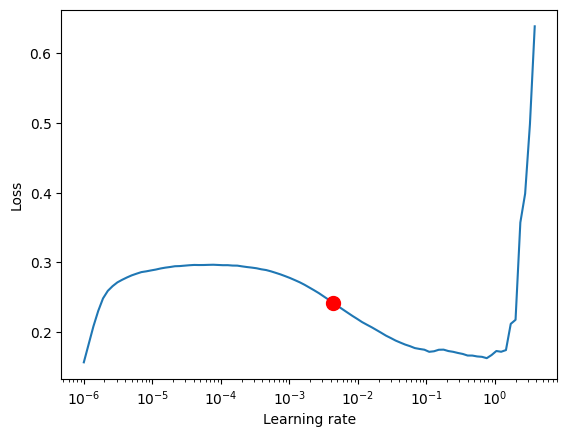

In [29]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## Train Model

In [102]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.13281581381983584,
    # limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.021949600344629006,
    hidden_size=14,
    attention_head_size=3,
    dropout=0.1835196955302717,
    hidden_continuous_size=9,
    loss=QuantileLoss(),
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="adam",
    reduce_on_plateau_patience=4,
)	


trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 108    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 548    |

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s, v_num=39, train_loss_step=0.0856]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 6/6 [00:01<00:00,  5.15it/s, v_num=39, train_loss_step=0.0532, val_loss=0.0607, train_loss_epoch=0.144]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s, v_num=39, train_loss_step=0.0455, val_loss=0.0497, train_loss_epoch=0.0602]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s, v_num=39, train_loss_step=0.0413, val_loss=0.0469, train_loss_epoch=0.0488]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s, v_num=39, train_loss_step=0.0402, val_loss=0.0395, train_loss_epoch=0.044] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 6/6 [00:01<00:00,  5.17it/s, v_num=39, train_loss_step=0.038, val_loss=0.0411, train_loss_epoch=0.040] 
Validation: |          | 0/?

## Hyperparameter tuning

In [31]:
import optuna
import statsmodels
print("✅ Optuna and statsmodels are available!")

✅ Optuna and statsmodels are available!


In [29]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-07-17 13:59:02,315] A new study created in memory with name: no-name-4d85e6af-62cd-429c-a5ed-b88dc6d92eb9
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropout", *dropout_range),
/usr/local/lib/python3.10/dist-packages/lightning/

{'gradient_clip_val': 0.13281581381983584, 'hidden_size': 14, 'dropout': 0.1835196955302717, 'hidden_continuous_size': 9, 'attention_head_size': 3, 'learning_rate': 0.021949600344629006}


# Evaluate

In [103]:
raw_predictions = tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

interpretation=tft.interpret_output(raw_predictions.output)

import torch
avg_importance = interpretation["decoder_variables"].mean(dim=0)

feature_names = ["irradiance", "temperature", "wind_speed"]

importance_dict = dict(zip(feature_names, avg_importance.tolist()))
sorted_importance = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

for feature, score in sorted_importance.items():
    print(f"{feature:20s} → {score:.4f}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


irradiance           → 0.9227
temperature          → 0.0292
wind_speed           → 0.0225


## Generate Predictions

In [104]:
predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))

y_pred = predictions.output.detach().cpu().numpy()
y_true = predictions.y[0].detach().cpu().numpy()  # Access first element of the tuple

# Optional: Inverse scale if needed
y_pred_inv = y_pred * pv_park.nominal_capacity
y_true_inv = y_true * pv_park.nominal_capacity

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Metrics

In [106]:
import json
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

metrics = {
    "validation": {
        "r2": float(r2_score(y_true_inv.flatten(), y_pred_inv.flatten())),
        "rmse": float(np.sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))),
        "mae": float(mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten()))
    }
}
print(metrics)

with open(f"{base_dir}/model/TFT/prediction-scenarios/openmeteo_base/validation/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)


{'validation': {'r2': 0.7696155717118421, 'rmse': 50.68830930499514, 'mae': 25.371403592084366}}


## Plots

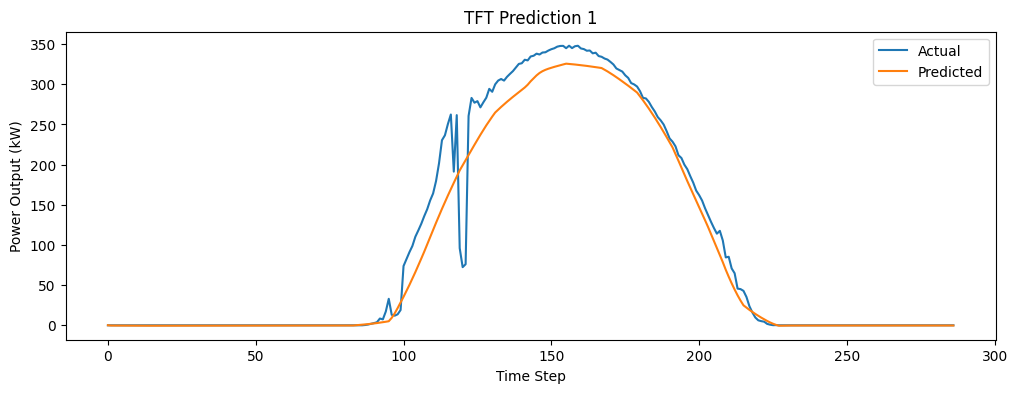

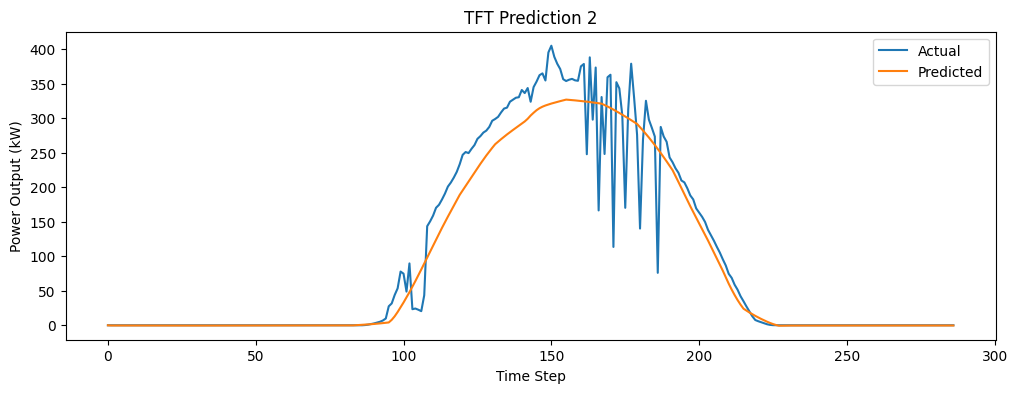

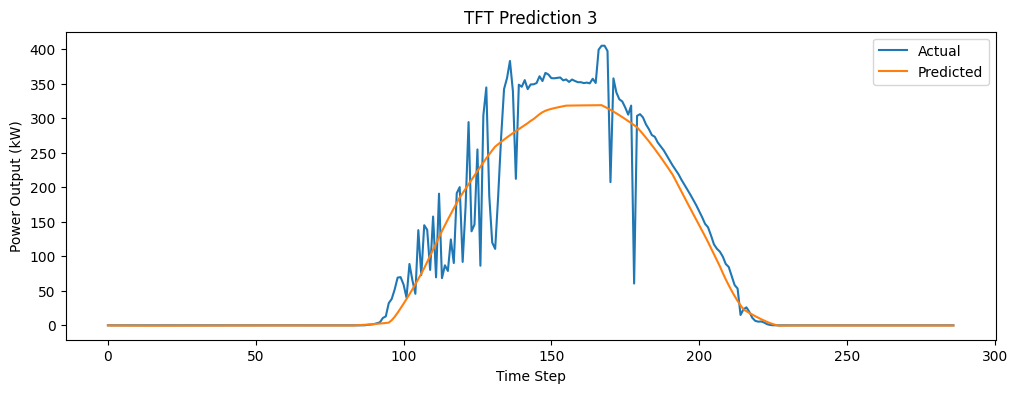

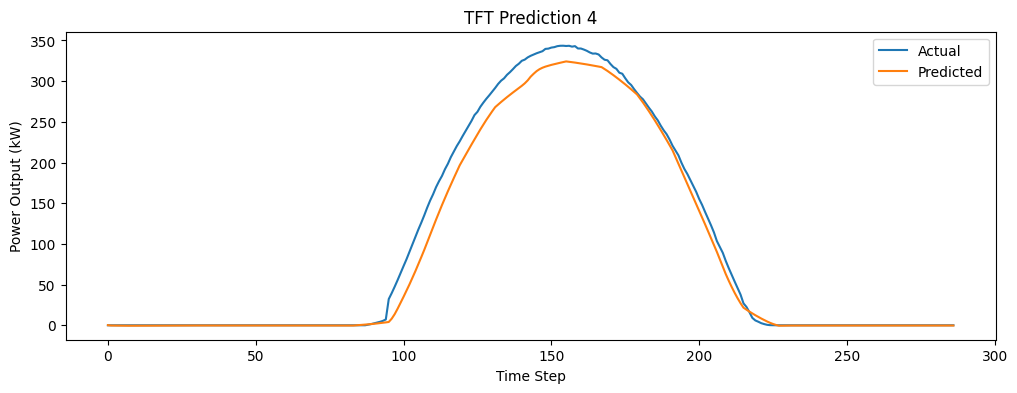

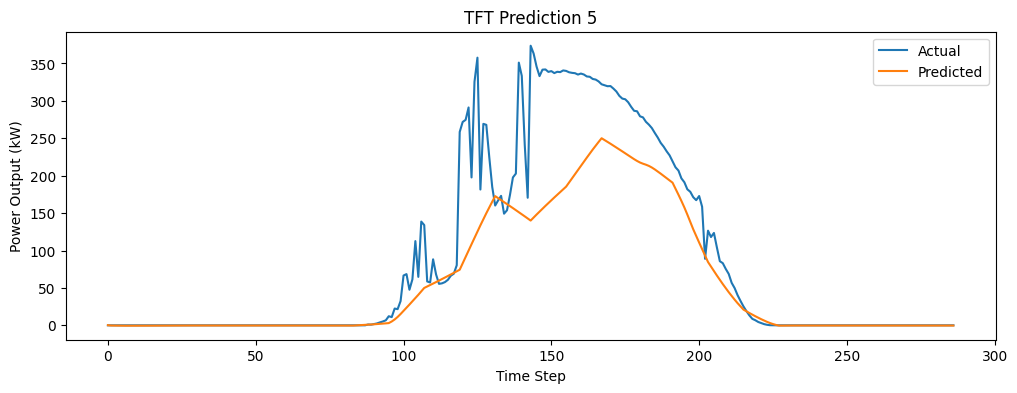

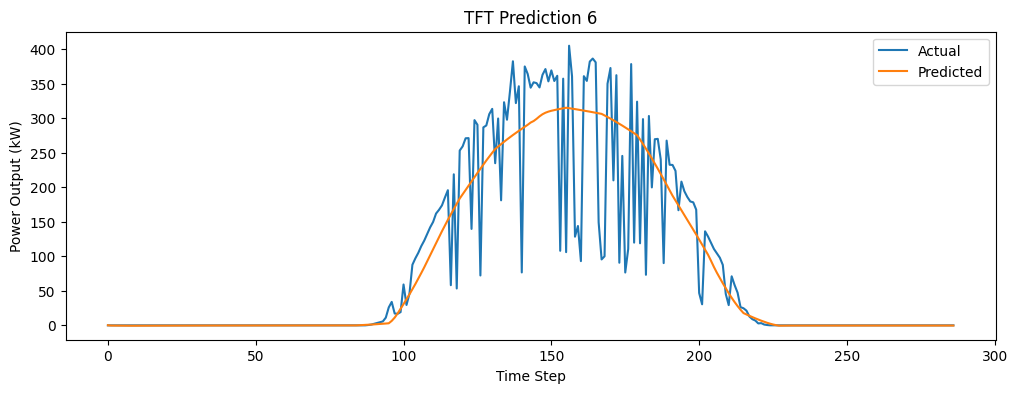

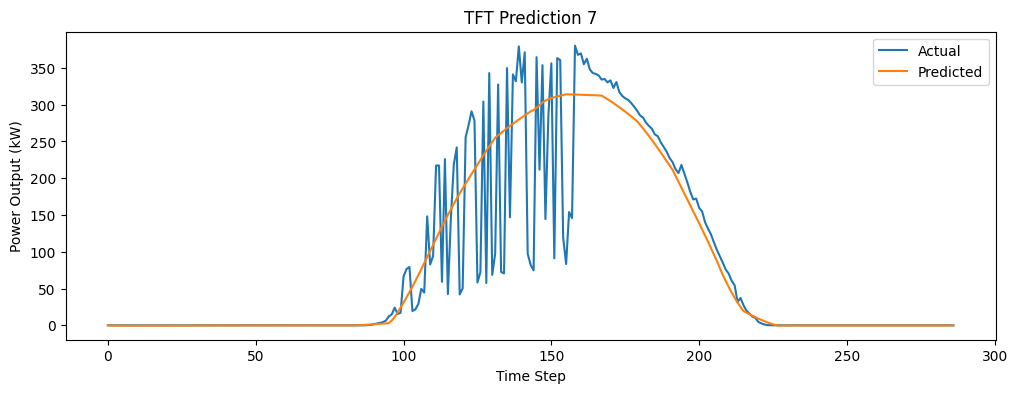

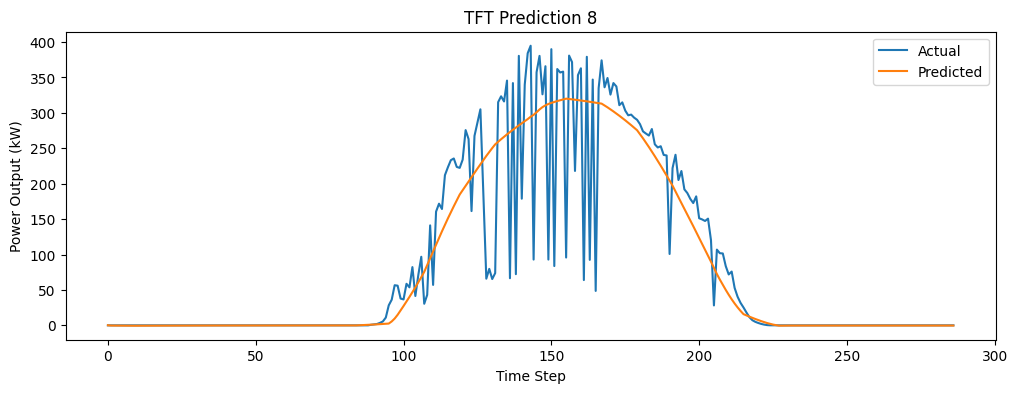

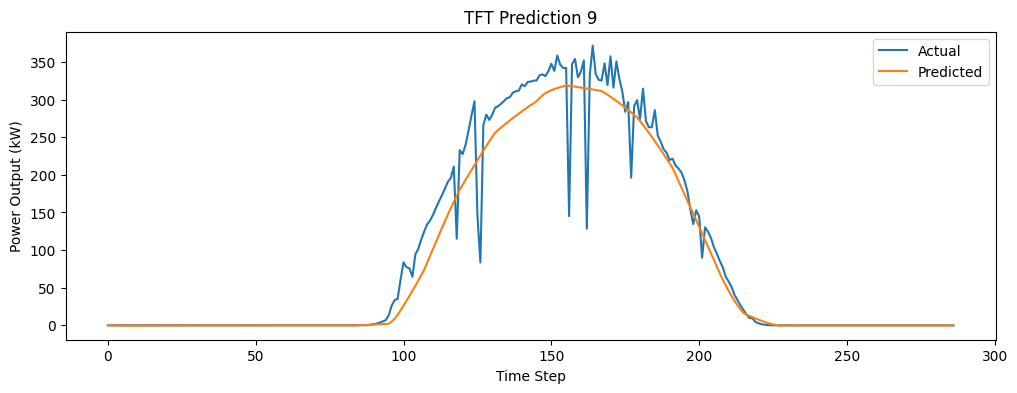

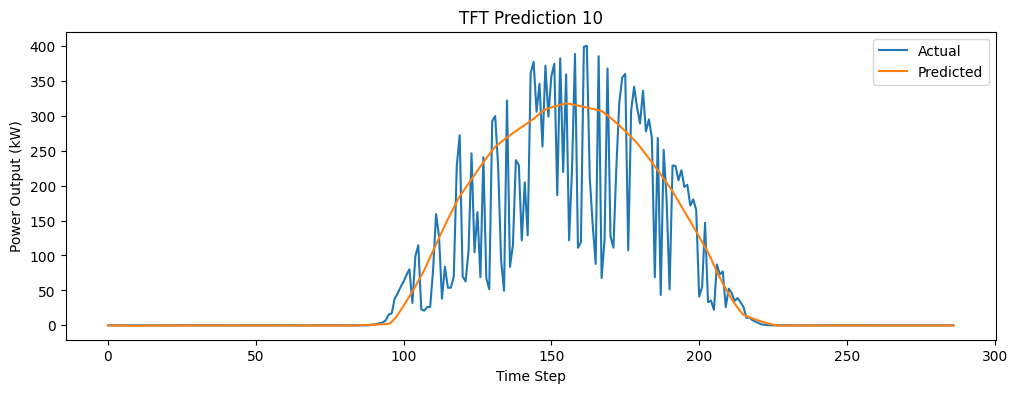

In [107]:
for i in range(10):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true_inv[i], label='Actual')
    plt.plot(y_pred_inv[i], label='Predicted')
    plt.title(f"TFT Prediction {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Power Output (kW)")  # Adjust based on units
    plt.legend()
    # plt.grid(True)
    plt.savefig(f"{base_dir}/model/TFT/prediction-scenarios/openmeteo_base/validation/prediction_{i+1}.png")
    plt.show()
    plt.close()

# Generate Data for another Park

## Load Data

In [108]:
df = pd.read_csv(f"{base_dir}/data/Sarafali-CN506/final/metadata.csv")
# Create PVPark instance from DataFrame
pv_park = PVPark.from_dataframe(df)

print(pv_park.location)
print(pv_park.tilt)
print(pv_park.azimuth)
print(pv_park.nominal_capacity)

Location: 
  name: Sarafali-CN506
  latitude: 35.13
  longitude: 25.259
  altitude: 334.0
  tz: Europe/Athens
20.0
180.0
1000.0


In [115]:
# Read data
df= pd.read_csv(f"{base_dir}/data/Sarafali-CN506/final/2024-04/data.csv")

open_meteo_df = pd.read_csv(f"{base_dir}/data/Gasi-CN448/final/open-meteo-data.csv")
open_meteo_df = open_meteo_df[(open_meteo_df['collect_time'] >= '2024-04-01') & (open_meteo_df['collect_time'] < '2024-05-01')]

open_meteo_df = open_meteo_df.reset_index(drop=True)
df = df.reset_index(drop=True)

df['irradiance'] = open_meteo_df['shortwave_radiation_instant']
df['dhi'] = open_meteo_df['diffuse_radiation_instant']
df['dni'] = open_meteo_df['direct_normal_irradiance_instant']
df['temperature'] = open_meteo_df['temperature_2m']
df['wind_speed'] = open_meteo_df['wind_speed_10m']

# Get Solar Position
df = get_solar_position(df, pv_park)

# # Estimate dhi & dni
# df = estimate_dhi_dni(df, pv_park)

# Get POA
df = get_poa(df, pv_park)

# Calculate AOI
df = calc_aoi(df, pv_park)

# Add sin and cos of time
df = add_sin_cos_time(df)

# Autoscale active power
df = scale_active_power(df, pv_park)

# Add group and time idx
df = add_group_and_time_idx(df)

# Clean and reorder
df = clean_and_reorder_df(df)

print(df)
print(len(df)/288)

      poa_global        collect_time
0            0.0 2024-04-01 00:00:00
1            0.0 2024-04-01 00:05:00
2            0.0 2024-04-01 00:10:00
3            0.0 2024-04-01 00:15:00
4            0.0 2024-04-01 00:20:00
...          ...                 ...
8635         0.0 2024-04-30 23:35:00
8636         0.0 2024-04-30 23:40:00
8637         0.0 2024-04-30 23:45:00
8638         0.0 2024-04-30 23:50:00
8639         0.0 2024-04-30 23:55:00

[8640 rows x 2 columns]
        group_id  time_idx  active_power  irradiance  poa_global  cos_zenith  \
0     2024-04-01         0           0.0         0.0         0.0         0.0   
1     2024-04-01         1           0.0         0.0         0.0         0.0   
2     2024-04-01         2           0.0         0.0         0.0         0.0   
3     2024-04-01         3           0.0         0.0         0.0         0.0   
4     2024-04-01         4           0.0         0.0         0.0         0.0   
...          ...       ...           ...         ..

/tmp/ipykernel_2660/2499243660.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poa_global['collect_time']=poa_global.index


## Create Timeseries Dataset and dataloader

In [116]:
# Use same parameters as training set
new_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,  # the one used to train the model
    df,
    predict=True,  # important for telling it we want to predict
)

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1709: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


In [117]:
new_dataloader = new_dataset.to_dataloader(train=False, batch_size=64)

## Generate and Evaluate

In [118]:
predictions = tft.predict(new_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))

y_pred = predictions.output.detach().cpu().numpy()
y_true = predictions.y[0].detach().cpu().numpy()  # Access first element of the tuple

# Optional: Inverse scale if needed
y_pred_inv = y_pred * pv_park.nominal_capacity
y_true_inv = y_true * pv_park.nominal_capacity

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


## Metrics

In [119]:
import json
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

metrics = {
    "test": {
        "r2": float(r2_score(y_true_inv.flatten(), y_pred_inv.flatten())),
        "rmse": float(np.sqrt(mean_squared_error(y_true_inv.flatten(), y_pred_inv.flatten()))),
        "mae": float(mean_absolute_error(y_true_inv.flatten(), y_pred_inv.flatten()))
    }
}
print(metrics)

with open(f"{base_dir}/model/TFT/prediction-scenarios/openmeteo_base/test/2024-04/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

{'test': {'r2': 0.8597494062515978, 'rmse': 109.21457364375047, 'mae': 52.48214102526552}}


## Plots

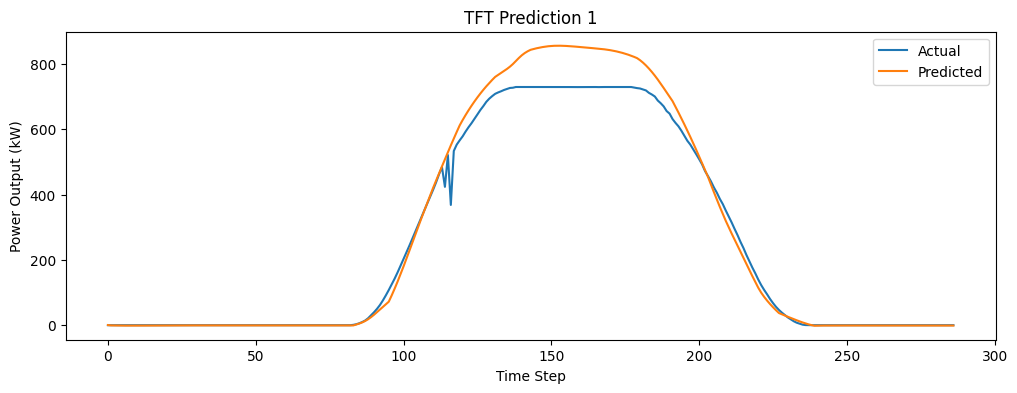

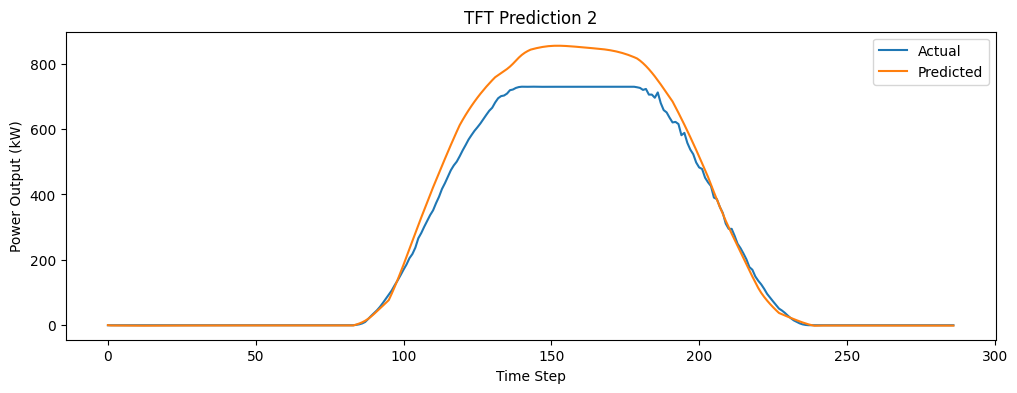

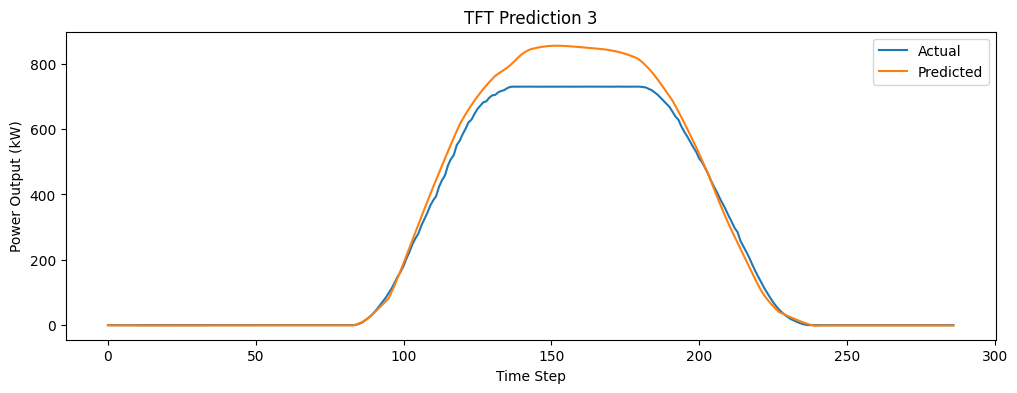

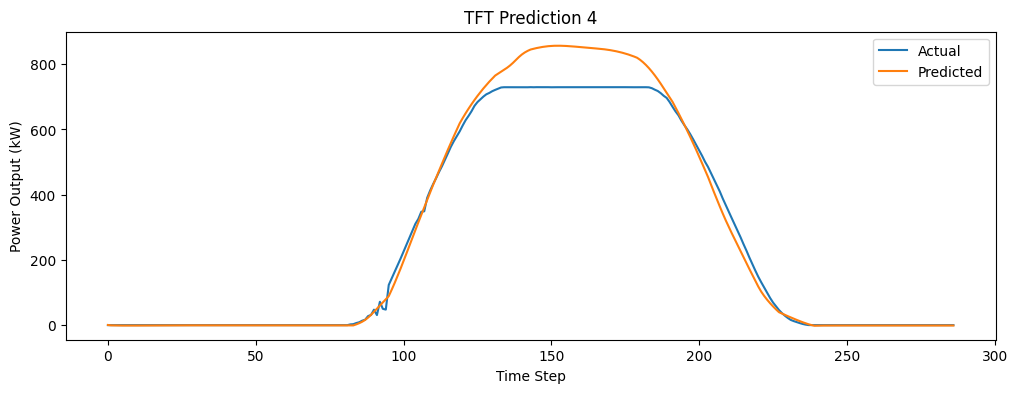

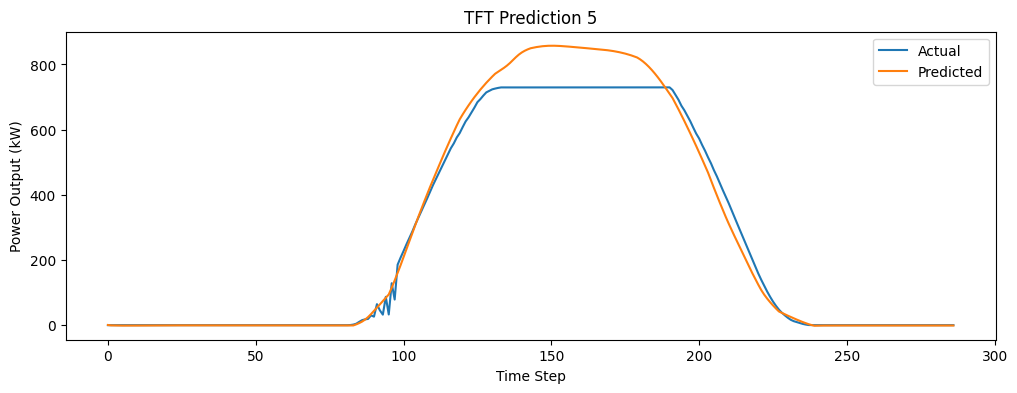

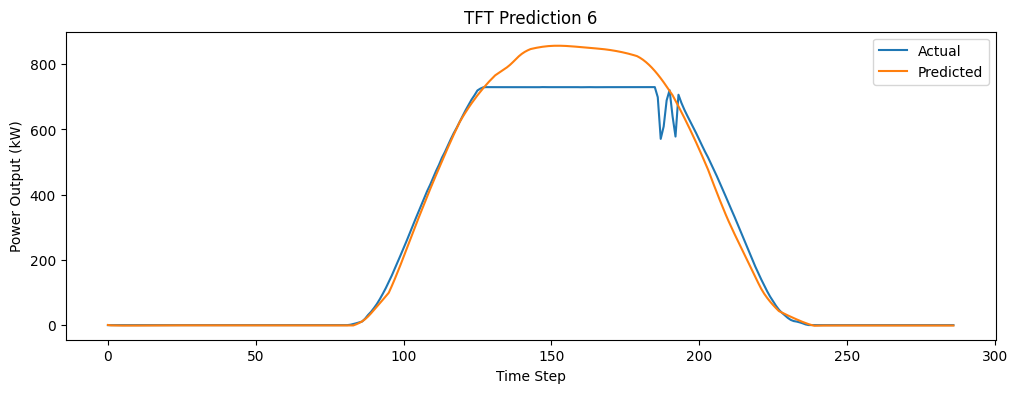

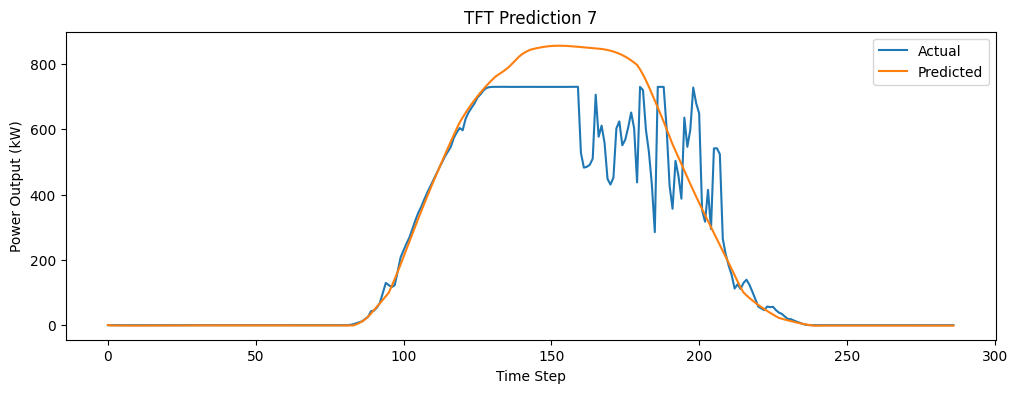

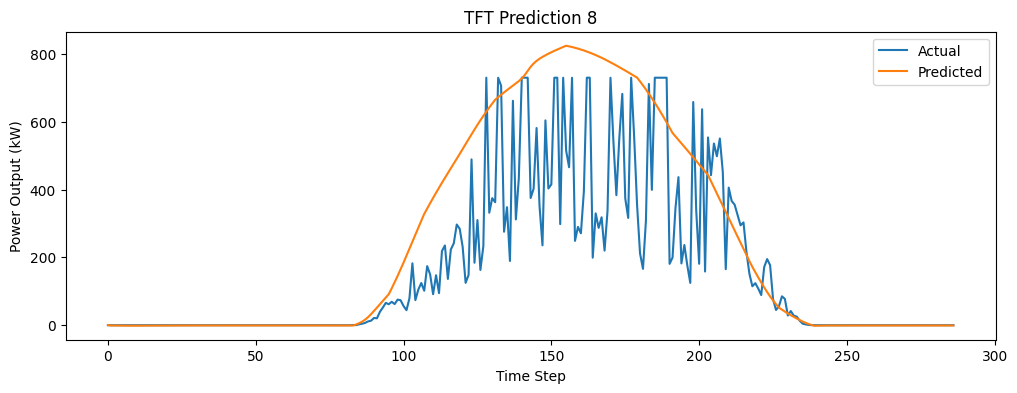

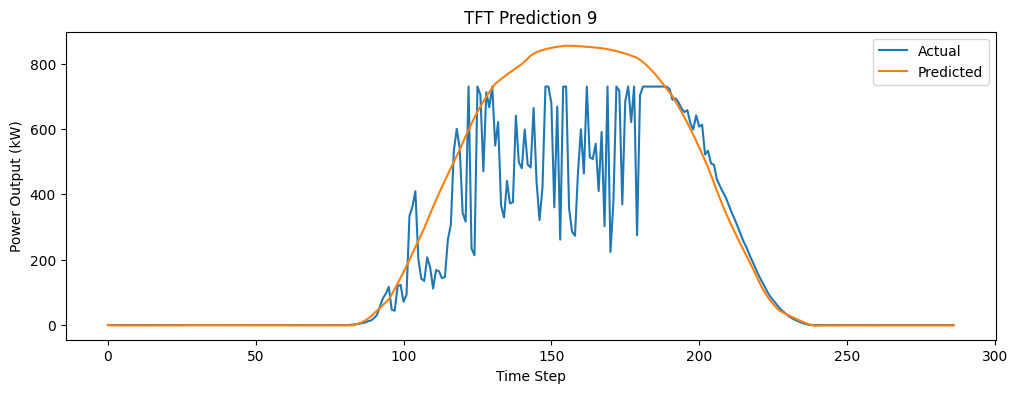

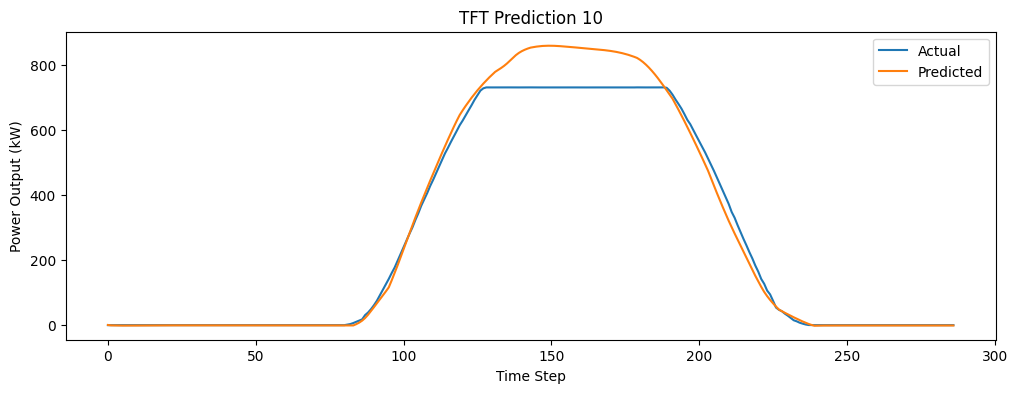

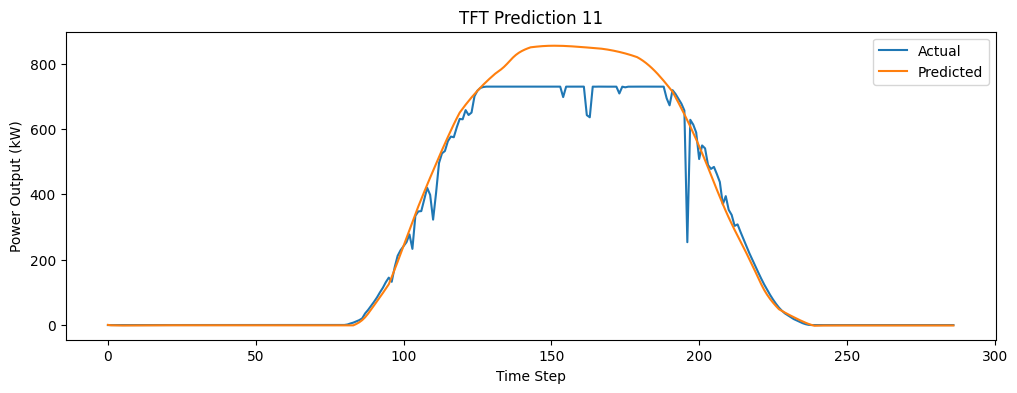

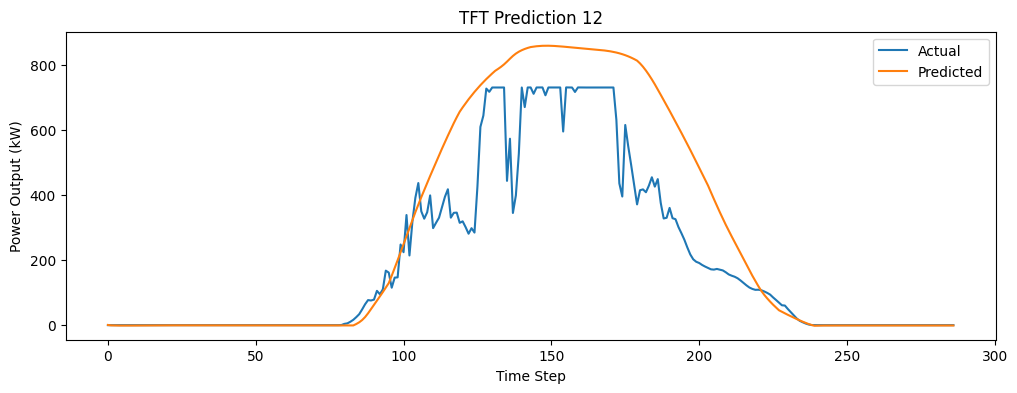

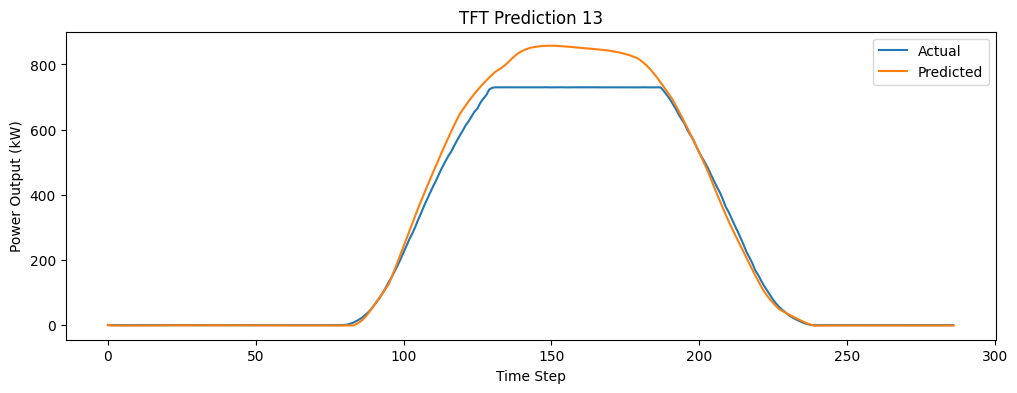

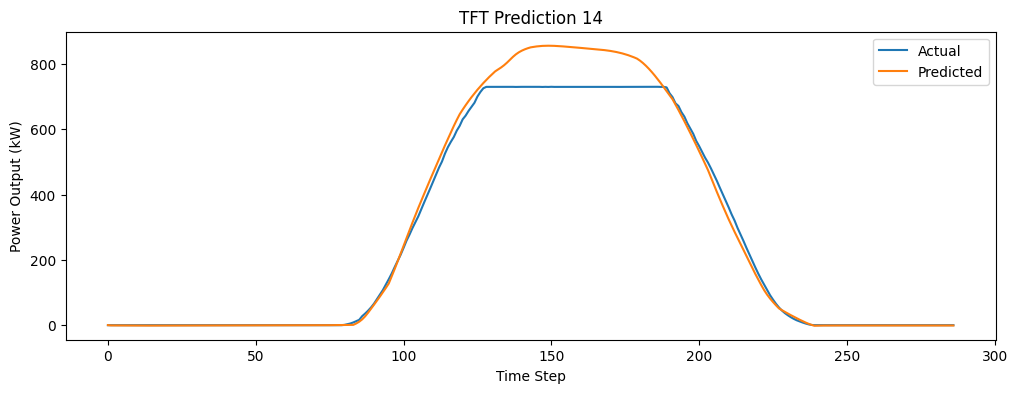

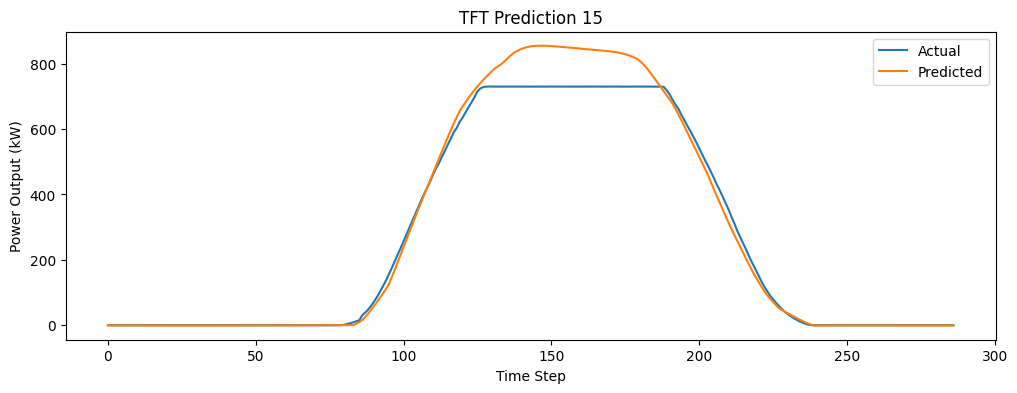

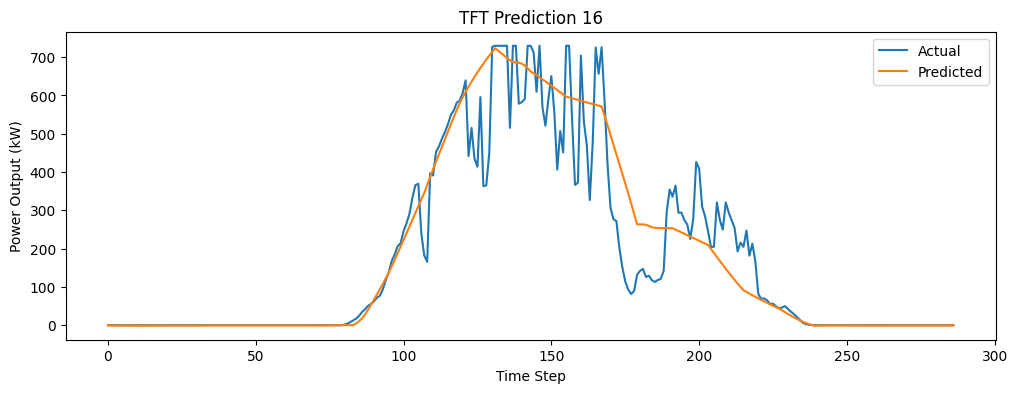

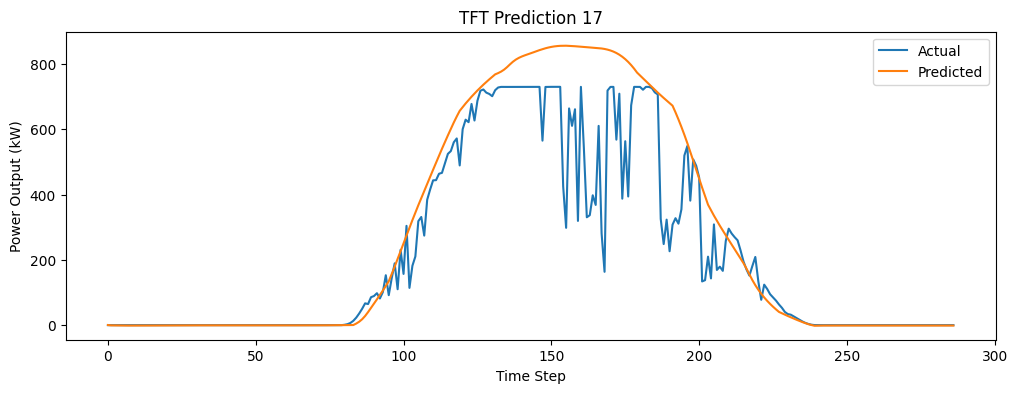

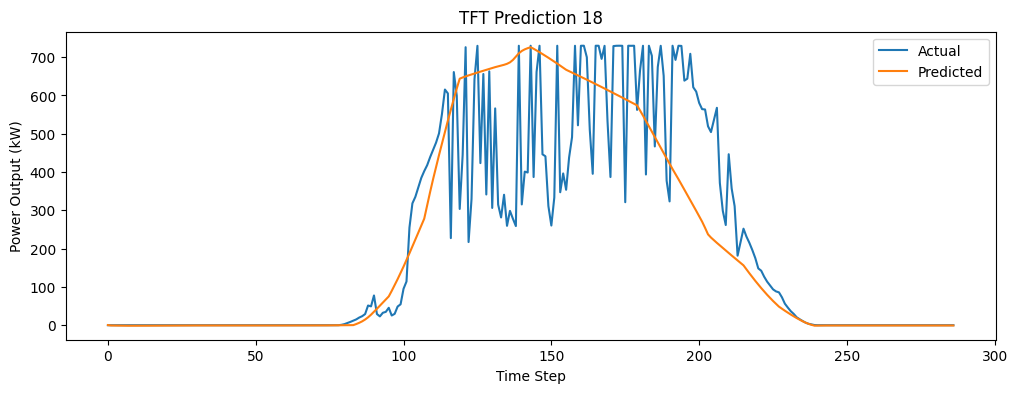

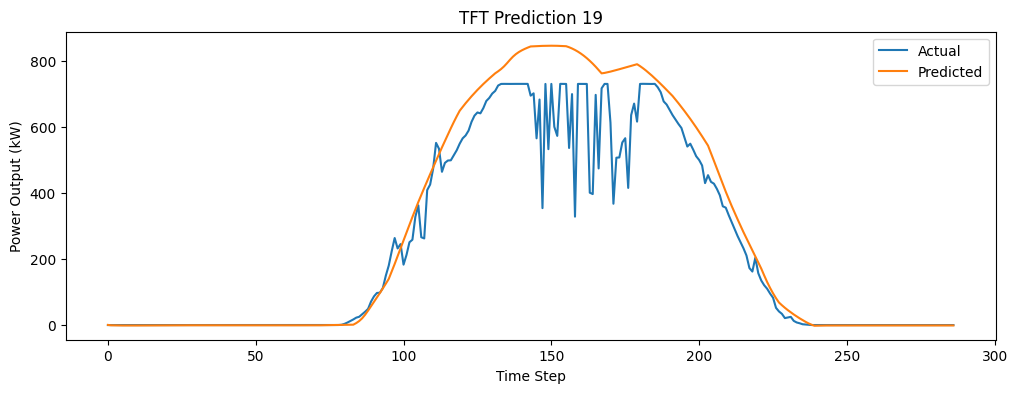

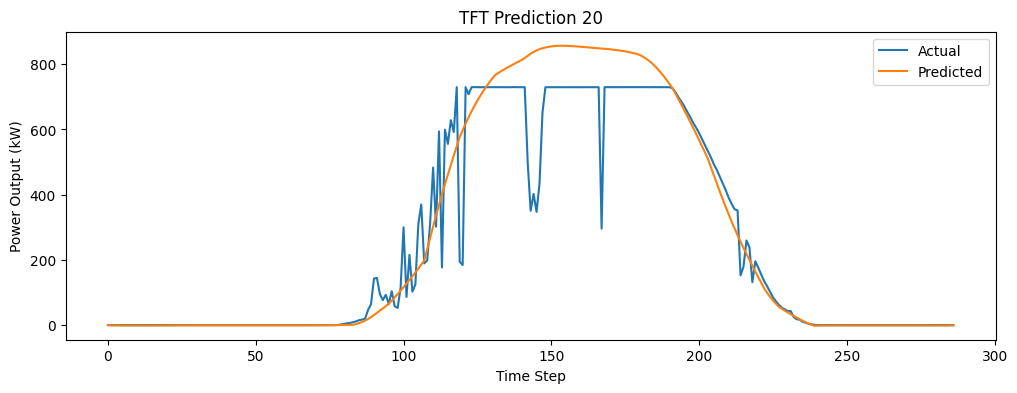

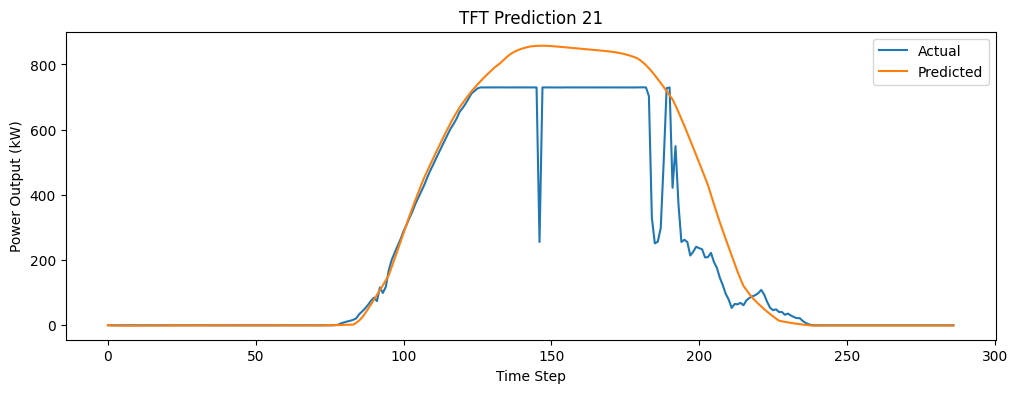

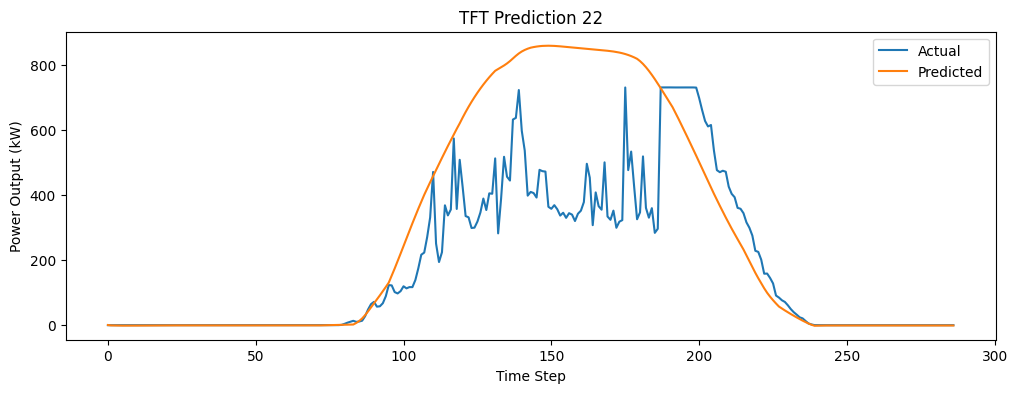

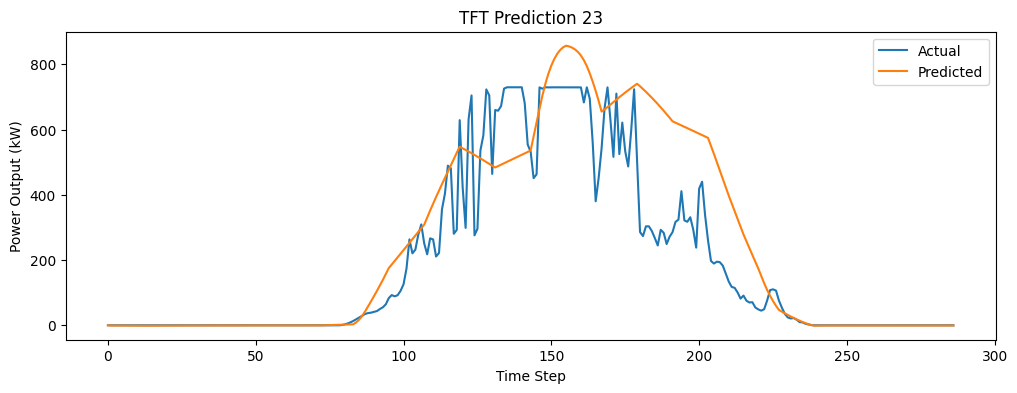

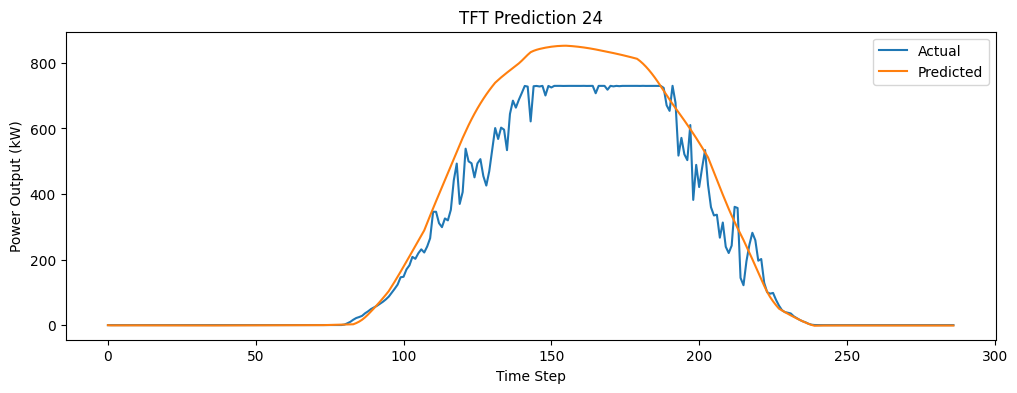

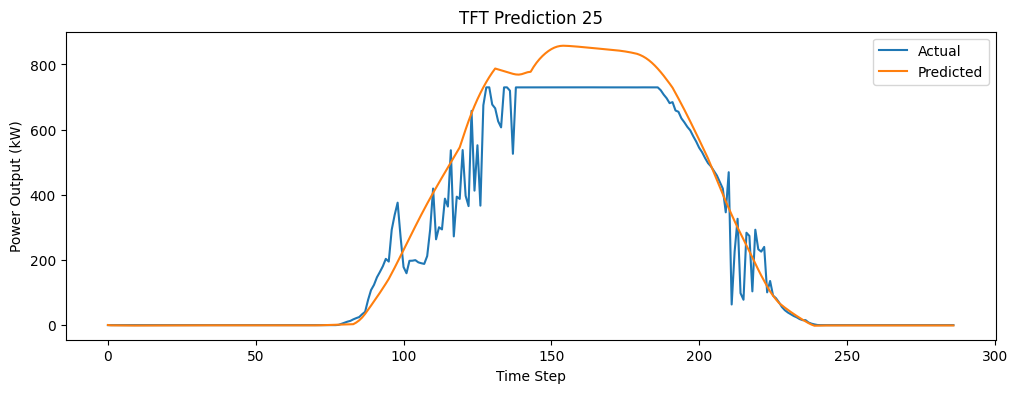

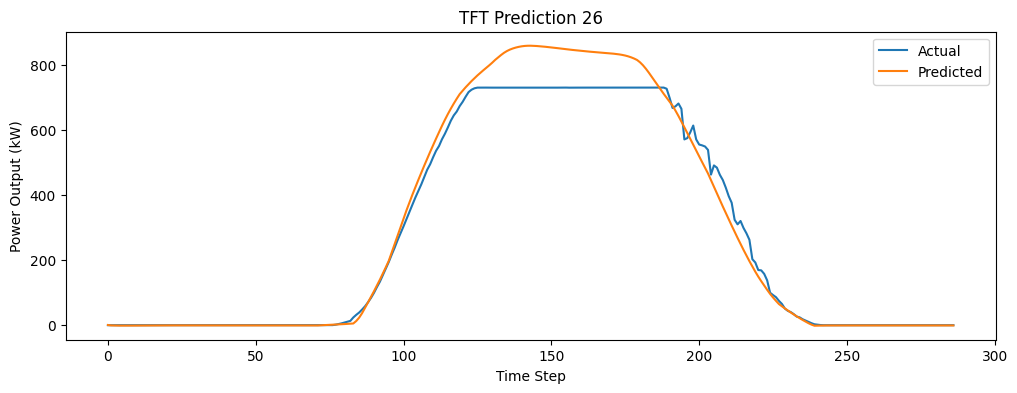

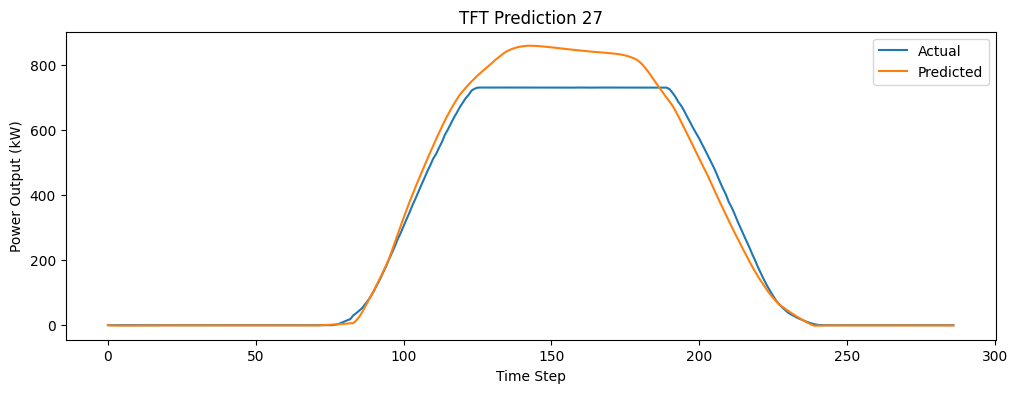

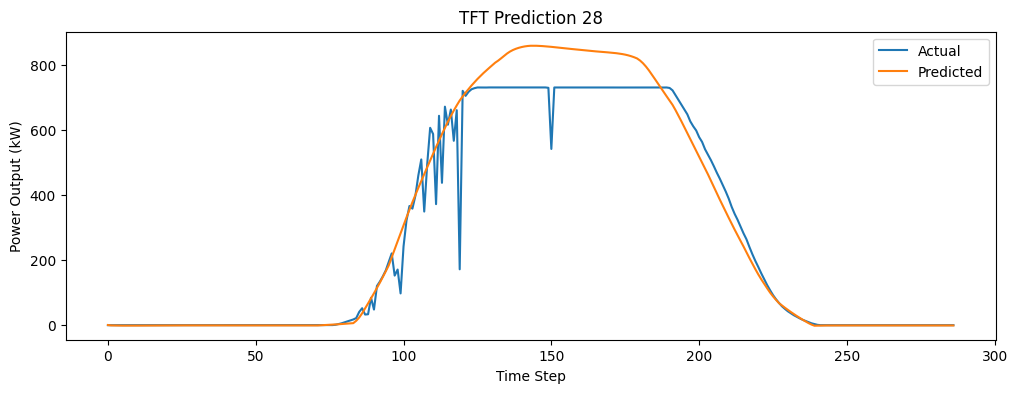

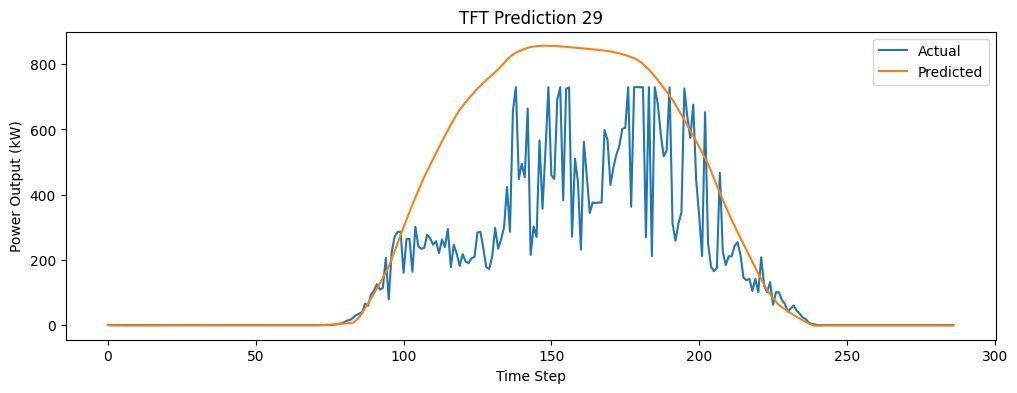

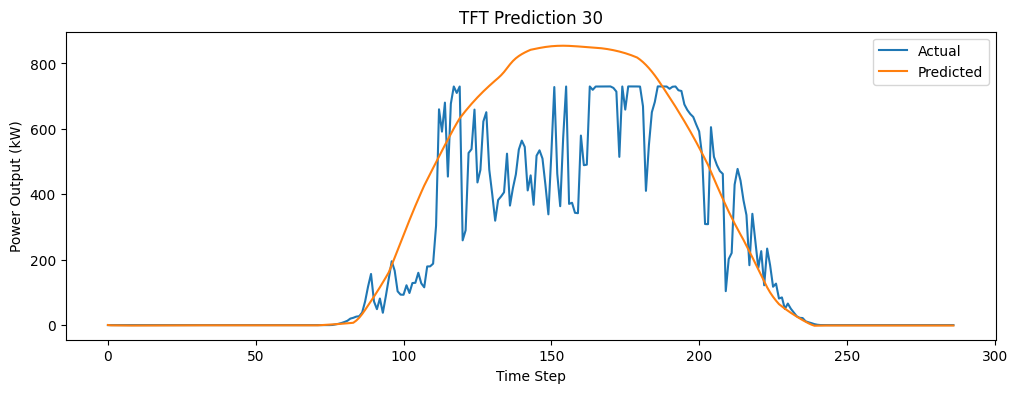

In [120]:
for i in range(30):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true_inv[i], label='Actual')
    plt.plot(y_pred_inv[i], label='Predicted')
    plt.title(f"TFT Prediction {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Power Output (kW)")  # Adjust based on units
    plt.legend()
    # plt.grid(True)
    plt.savefig(f"{base_dir}/model/TFT/prediction-scenarios/openmeteo_base/test/2024-04/prediction_{i+1}.png")
    plt.show()
    plt.close()